# Using shallow water equations to understand large-scale dynamics
### MAQ - 32806, Chiel van Heerwaarden, 2016
In this tutorial you will use the previously derived shallow water equations to solve the famous Rossby adjustment problem in which a perturbation is added to a layer of fluid.

## 1. Bla
More bla.

In [1]:
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


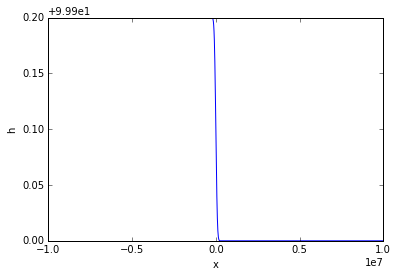

In [2]:
nx = 2001
L = 1.e7
x = np.linspace(-L, L, nx)
dx = x[1]-x[0]
u0 = np.zeros(nx)
v0 = np.zeros(nx)
h_ref   = 100.
h_prime = 0.1
h0 = np.copy(x)
for i in range(nx):
    h0[i] = h_ref - h_prime*np.math.erf(h0[i]/(10*dx))

pl.plot(x, h0, 'b-')
pl.xlabel('x')
pl.ylabel('h');

In [3]:
f = 1.e-4
g = 9.81
try:
    Lr = (g*h_ref)**.5 / f
except ZeroDivisionError:
    Lr = np.infty
finally:
    print "Rossby radius of deformation = {0} m".format(Lr)
    print "Lr / L = {0}".format(Lr/L)

Rossby radius of deformation = 313209.195267 m
Lr / L = 0.0313209195267


In [4]:
u = np.copy(u0)
v = np.copy(v0)
h = np.copy(h0)

nt = 150000
ni = 500
dt = 4.

h_out = np.zeros((nt/ni+1, nx))
h_out[0,:] = h0[:]

for n in range(nt+1):
    dudt = np.zeros(nx)
    dvdt = np.zeros(nx)
    dhdt = np.zeros(nx)

    # Time integrate left boundary, used biased stencil.
    dudt[0] = -u[0]*(u[1]-u[0])/dx + f*v[0] - g*(h[1]-h[0])/dx
    dvdt[0] = -u[0]*(v[1]-v[0])/dx - f*u[0]
    dhdt[0] = -h[0]*(u[1]-u[0])/dx
    
    # Time integrate, use centered stencil.
    dudt[1:-1] = -u[1:-1]*(u[2::]-u[0:-2])/(2.*dx) + f*v[1:-1] - g*(h[2::]-h[0:-2])/(2.*dx)
    dvdt[1:-1] = -u[1:-1]*(v[2::]-v[0:-2])/(2.*dx) - f*u[1:-1]
    dhdt[1:-1] = -h[1:-1]*(u[2::]-u[0:-2])/(2.*dx)
    
    # Time integrate right boundary, use biased stencil.
    dudt[-1] = -u[-1]*(u[-1]-u[-2])/dx + f*v[-1] - g*(h[-1]-h[-2])/dx
    dvdt[-1] = -u[-1]*(v[-1]-v[-2])/dx - f*u[-1]
    dhdt[-1] = -h[-1]*(u[-1]-u[-2])/dx
    
    u += dt * dudt
    v += dt * dvdt
    h += dt * dhdt
    
    if (n%ni == 0):
        h_out[n/ni,:] = h[:]

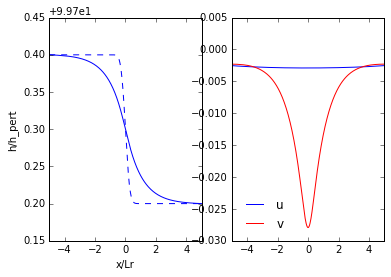

In [5]:
pl.figure()
pl.subplot(121)
pl.plot(x/Lr, h , 'b-' )
pl.plot(x/Lr, h0, 'b--')
pl.xlabel('x/Lr')
pl.ylabel('h/h_pert')
pl.xlim(-5, 5)
pl.subplot(122)
pl.plot(x/Lr, u, 'b-', label='u')
pl.plot(x/Lr, v, 'r-', label='v')
pl.xlim(-5, 5)
pl.legend(loc=0, frameon=False);

In [6]:
q0 = f/h0
q  = np.gradie
#pl.plot(x, q )
#pl.plot(x, q0)

In [7]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = pl.figure()
xmin, xmax = min(x), max(x)
hmin, hmax = min(h0), max(h0)
hmin -= 0.2*(hmax-hmin)
hmax += 0.2*(hmax-hmin)
ax = pl.axes(xlim=(xmin, xmax), ylim=(hmin, hmax), xlabel='x', ylabel='h')
ax.plot(x, h_out[0,:], 'b--')
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data(x, h_out[0,:])
    return line,

def animate(i):
    line.set_data(x, h_out[i,:])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=h_out.shape[0], interval=1, blit=True)

# call our new function to display the animation
display_animation(anim)